12.6 첫번째 예시 : 완전한 백테스트

In [3]:
from data_processing import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#Chap 1 데이터

data_raw = pd.read_csv('data_ml.csv')
idx_date = data_raw.index[(
    data_raw['date'] > '1999-12-31') & (
    data_raw['date'] < '2019-01-01')].tolist()

#날짜를 받기 위한 인덱스 생성
data_ml = data_raw.iloc[idx_date]
#날짜 인덱스에 따라 데이터셋 필터링
data_ml.iloc[0:6, 0:6]

features = list(data_ml.iloc[:, 3:95].columns)
# 특성의 열 이름 저장 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd",
                  "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

separation_date = "2014-01-15"
idx_train = data_ml.index[(data_ml['date']<separation_date)].tolist()
idx_test = data_ml.index[(data_ml['date']>=separation_date)].tolist()

stock_ids_short = []
stock_days = []

# 각 주식별 데이터 포인트 개수 세기
stock_ids = data_ml['stock_id'].unique()
stock_days = data_ml[['date', 'stock_id']].groupby(
    ['stock_id']).count().reset_index()

# 데이터가 모두 있는 주식을 리스트로 변환
stock_ids_short = stock_days.loc[
    stock_days['date'] == (stock_days['date'].max())]
stock_ids_short = stock_ids_short['stock_id'].unique()
is_stock_ids_short = data_ml['stock_id'].isin(stock_ids_short)
returns = data_ml[is_stock_ids_short].pivot(
    index='date', columns='stock_id', values='R1M_Usd'
)

1. 변수 생성 및 초기화

In [4]:
import datetime as dt
from datetime import datetime
sep_oos = "2007-01-01" #백테스트 시작 시점
ticks = list(data_ml['stock_id'].unique()) # 모든 자산들 식별 코드 리스트
N = len(ticks) #최대 자산 개수
t_oos = list(returns.index[returns.index>sep_oos].values) #표본 외 날짜
t_as = list(returns.index.values) #전체 날짜
Tt = len(t_oos) #날짜 개수
nb_port = 2 #포트폴리오 전략 개수

#포트폴리오 가중치 및 수익률 초기화
portf_weights = np.zeros(shape=(Tt, nb_port, max(ticks)+1))
portf_returns = np.zeros(shape=(Tt, nb_port))

2. 메인 함수에서 전략 정의

In [5]:
import xgboost as xgb
# XGB, EW 
def weights_xgb(train_data, test_data, features):
    # 독립 변수
    train_features = train_data[features]
    train_label = train_data['R12M_Usd'] / np.exp(train_data['Vol1Y_Usd'])
    # 종속 변수
    ind = (train_label < np.quantile(
        train_label, 0.2)) | (train_label > np.quantile(train_label, 0.8)) # 범위 필터
    train_features = train_features.loc[ind]
    train_label = train_label.loc[ind]
    train_matrix = xgb.DMatrix(train_features, label=train_label)
    params={'eta':0.3,
            'objective':'reg:squarederror',
            'max_depth':4}
    fit_xgb = xgb.train(params, train_matrix, num_boost_round=80)
    
    test_features = test_data[features]
    test_matrix = xgb.DMatrix(test_features)
    pred = fit_xgb.predict(test_matrix)
    w_names = test_data["stock_id"]
    w = pred > np.median(pred)
    w = w / np.sum(w)
    return w, w_names

In [6]:
# 동일가중 포트폴리오
def portf_compo(train_data, test_data, features, j):
    if j == 0: #벤치마크
        N = len(test_data['stock_id'])
        w = np.repeat(1/N,N)
        w_names = test_data['stock_id']
        return w, w_names
    elif j == 1:
        return weights_xgb(train_data, test_data, features)

In [8]:
m_offset = 12 # 버퍼 기간을 위한 오프셋 
train_size = 5 # 훈련셋 사이즈 연수
for t in range(len(t_oos)-1): #선도 수익률 금지
    ind = (
        data_ml['date'] < datetime.strftime(
            datetime.strptime(t_oos[t], "%Y-%m-%d") - dt.timedelta(m_offset*30), "%Y-%m-%d")) & (
        data_ml['date'] > datetime.strftime(
            datetime.strptime(t_oos[t], "%Y-%m-%d") - dt.timedelta(m_offset*30) - dt.timedelta(365 * train_size), "%Y-%m-%d"))
    train_data = data_ml.loc[ind,:]
    test_data = data_ml.loc[data_ml['date'] == t_oos[t], :]
    realized_returns = test_data["R1M_Usd"]
    
    # 1개월 홀딩 기간을 고려한 수익률 계산
    for j in range(nb_port):
        temp_weights, stocks = portf_compo(
            train_data, test_data, features, j)
        portf_weights[t, j, stocks] = temp_weights
        portf_returns[t,j] = np.sum(temp_weights * realized_returns) #수익률 계산

In [9]:
# 회전율 계산 함수
def turnover(weights, asset_returns, t_oos):
    turn = 0
    for t in range(1, len(t_oos)):
        realized_returns = asset_returns[returns.index == t_oos[t]].values
        prior_weights = weights[t-1] * (1+realized_returns)
        turn = turn + np.sum(np.abs(
            weights[t] - prior_weights/np.sum(prior_weights)))
    return turn / (len(t_oos) - 1)

In [10]:
# 주요 지표 계산 함수
def perf_met(portf_returns, weights, asset_returns, t_oos):
    avg_ret = np.nanmean(portf_returns) # 산술평균
    vol = np.nanstd(portf_returns, ddof=1) # 변동성
    Sharpe_ratio = avg_ret / vol #샤프비율
    VaR_5 = np.quantile(portf_returns, 0.05) #VaR
    turn = turnover(weights, asset_returns, t_oos) #회전율
    met = [avg_ret, vol, Sharpe_ratio, VaR_5, turn]
    return met

In [11]:
# 다양한 전략 반복
def perf_met_multi(portf_returns, weights, asset_returns, t_oos, strat_name):
    J = weights.shape[1]
    met = []
    for j in range(J):
        temp_met = perf_met(portf_returns[:, j], weights[:,j,:], asset_returns, t_oos)
        met.append(temp_met)
    return pd.DataFrame(met, index=strat_name, columns = ['avg_ret', 'vol', 'Sharpe_ratio', 'VaR_5', 'turn'])

In [12]:
asset_returns = data_ml[['date', 'stock_id', 'R1M_Usd']].pivot(
    index='date', columns='stock_id', values='R1M_Usd')
na = list(set(np.arange(
    max(asset_returns.columns)+1)).difference(set(asset_returns.columns)))
asset_returns[na] = 0
asset_returns = asset_returns.loc[:, sorted(asset_returns.columns)]
asset_returns.fillna(0, inplace=True)
perf_met_multi(portf_returns, portf_weights, asset_returns, t_oos, strat_name=["EW","XGB_SR"])

,avg_ret,vol,Sharpe_ratio,VaR_5,turn
EW,0.009697,0.056429,0.171848,-0.077125,0.071451
XGB_SR,0.012585,0.063219,0.199066,-0.087143,0.563090


C:\Users\Administrator\AppData\Local\Temp\ipykernel_42876\3239909270.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  g2[["benchmark", "ml_based"]].pct_change(1).plot.bar(figsize=[16,6], ylabel = 'Yearly performance')


<Axes: xlabel='date', ylabel='Yearly performance'>

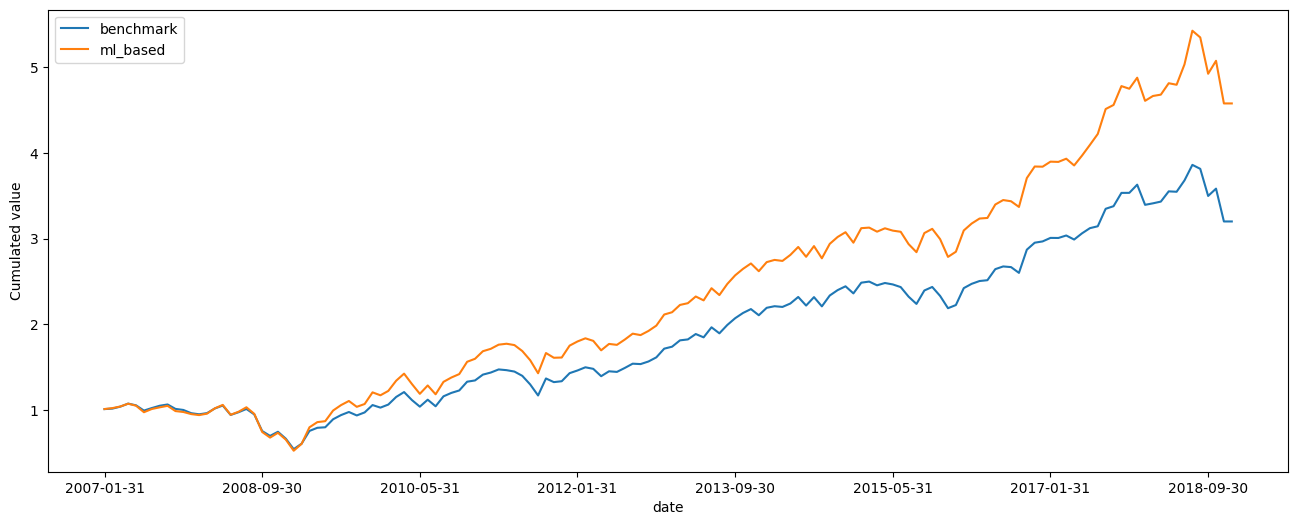

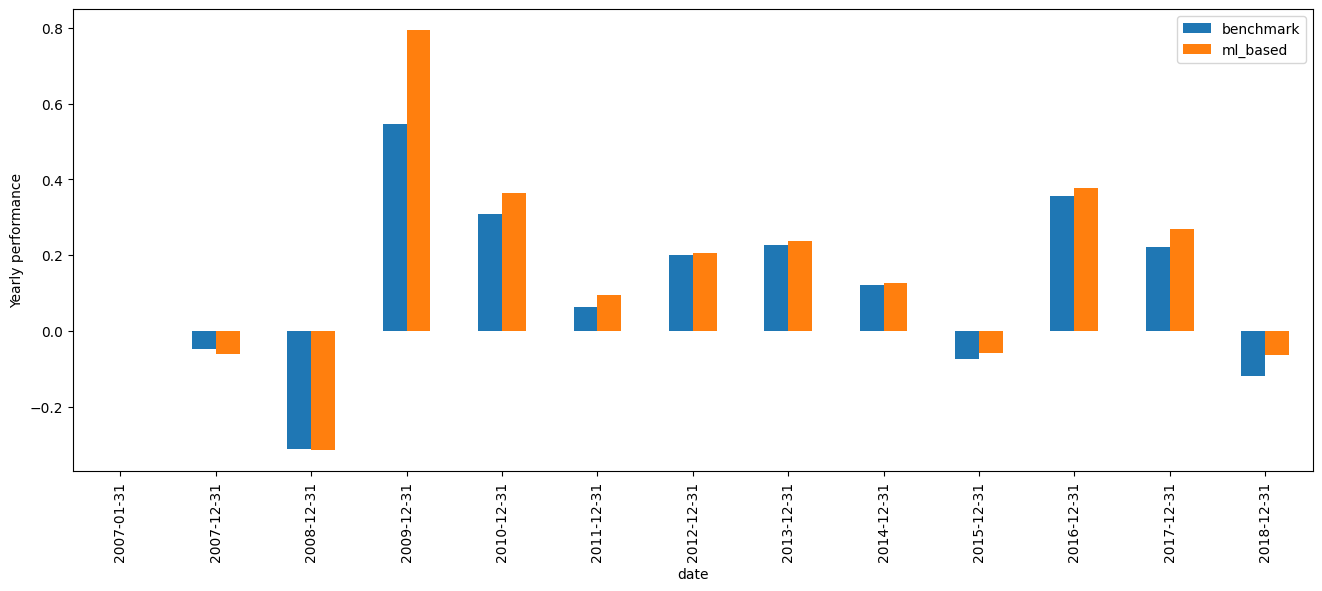

In [15]:
#그래프
g1 = pd.DataFrame(
    [t_oos, np.cumprod(
        1+portf_returns[:,0]), np.cumprod(
        1+portf_returns[:,1])], index = ["date", "benchmark", "ml_based"]).T
g1.reset_index(inplace=True)

g1['date_month'] = pd.to_datetime(g1['date']).dt.month
g1.set_index('date', inplace=True)
g2 = g1[g1['date_month'] == 12]
g2 = pd.concat([g2, g1.iloc[[0]]])
g2.sort_index(inplace=True)

g1[["benchmark", "ml_based"]].plot(figsize=[16,6], ylabel='Cumulated value')
g2[["benchmark", "ml_based"]].pct_change(1).plot.bar(figsize=[16,6], ylabel = 'Yearly performance')

KeyError: 'benchmark'

<Figure size 1600x600 with 0 Axes>